In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
#import glob
#import plotly.graph_objects as go
#
from sklearn.preprocessing import MinMaxScaler#, StandardScaler
#from tensorflow.keras.layers import Input, Dense, Activation, Lambda
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.losses import MeanSquaredError, MeanSquaredError
#
#import random
import numpy as np
#from keras import backend as K
#import os
#from contextlib import redirect_stdout
#
import tensorflow as tf
#
#tf.keras.backend.set_floatx('float32')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re

In [2]:
features = 'paths-exp6-coords4'
num_hidden_nodes = [16, 32]
activations = 2*['tanh']
num_atoms = 32
epoch = 100
train = True

# %%
network = '_'.join([str(x) for x in num_hidden_nodes])
num_hidden_layers = len(num_hidden_nodes)
model_name = features+'--'+network+activations[0]

In [3]:
f_type, n_hops, n_nei = model_name.split('-')[0], *re.findall('\d+', features)

# %%
X_train = pd.read_parquet('X_'+f_type+'_train.parquet')
X_dev = pd.read_parquet('X_'+f_type+'_dev.parquet')
X_test = pd.read_parquet('X_'+f_type+'_test.parquet')
# %%
cols_hops = X_train.columns[X_train.columns.str.startswith(
    tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
cols_neis = X_train.columns[X_train.columns.str.startswith(
    tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']
# %%
X_train = X_train.loc[:, cols].copy()
X_dev = X_dev.loc[:, cols].copy()
X_test = X_test.loc[:, cols].copy()

# %%
f_train = pd.read_parquet('y_train.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

f_dev = pd.read_parquet('y_dev.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

f_test = pd.read_parquet('y_test.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

In [4]:
scaler = MinMaxScaler().fit(X_train)

X_test = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=X_test.index)
X_dev = pd.DataFrame(scaler.transform(
    X_dev), columns=X_dev.columns, index=X_dev.index)
X_train = pd.DataFrame(scaler.transform(
    X_train), columns=X_train.columns, index=X_train.index)

In [5]:
X_train2 = X_train.to_numpy().reshape(-1, num_atoms, X_train.shape[-1])
X_dev2 = X_dev.to_numpy().reshape(-1, num_atoms, X_dev.shape[-1])
X_test2 = X_test.to_numpy().reshape(-1,  num_atoms, X_test.shape[-1])

In [6]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=0)

In [7]:
model = tf.keras.models.load_model('./results/'+model_name+'/checkpoints', compile = False)#, custom_objects={'loss': my_loss_fn})

In [8]:
predictions = {}
xs2 = [X_train2, X_dev2, X_test2]
ys2 = [f_train, f_dev, f_test]
xs = [X_train, X_dev, X_test]
for i, set in enumerate(['train', 'dev', 'test']):
    xvals = xs2[i]  # .to_numpy().reshape(-1, num_atoms, xs[i].shape[-1])
    y_pred2 = model.predict_on_batch(xvals)
    y_pred = pd.DataFrame(y_pred2.reshape(-1, 3),
                          columns=['x_hat', 'y_hat', 'z_hat'], index=xs[i].index)
    y_real = pd.DataFrame(ys2[i].reshape(-1, 3),
                          columns=['x', 'y', 'z'], index=xs[i].index)
    df_pred = pd.concat([y_real, y_pred], axis=1)
    predictions[set] = df_pred
df_pred = pd.concat(predictions)
df_pred['f'] = np.sqrt((df_pred[['x', 'y', 'z']]**2).sum(axis=1))
df_pred['f_hat'] = np.sqrt((df_pred[['x_hat', 'y_hat', 'z_hat']]**2).sum(axis=1))

Text(0, 0.5, '$\\hat{f}$')

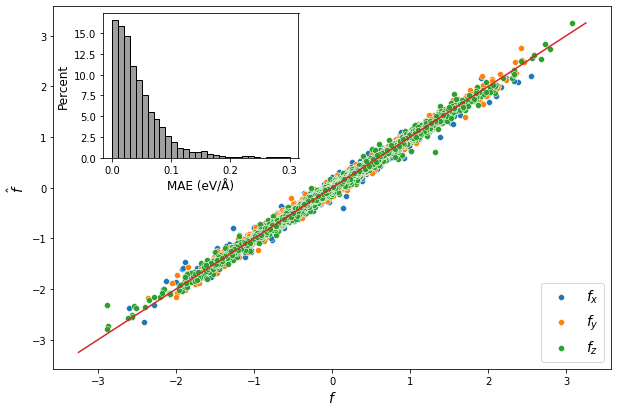

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

pal = sns.color_palette()

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0], label = r'$f_x$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1], label = r'$f_y$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2], label = r'$f_z$')

sns.lineplot(x = [-3.25, 3.25], y =  [-3.25, 3.25], color = pal[3], ax = axs)

axins = inset_axes(axs, width="35%", height="40%", loc=2, bbox_to_anchor=(0, 0.12, 1, 1), bbox_transform=axs.transAxes, borderpad = 5)#,)

sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins, stat = 'percent', bins = 30, binrange=(0,0.3), color = pal[7])
axins.set_xlabel('MAE (eV/Å)', fontsize = 12)
axins.set_ylabel('Percent', fontsize = 12)

axs.legend(loc = 4, fontsize = 14)
axs.set_xlabel(r'$f$', fontsize = 14)
axs.set_ylabel(r'$\hat{f}$', fontsize = 14)

#axins.get_yaxis().set_visible(False)

#plt.tight_layout()
